In [28]:
# This notebook takes the input dataset, finds quartiles for the medical interventions (IV in, max vaso in)
# for each block.
# We then discretise actions in the original dataset according to what bin they fall in, and then save 
# a new dataframe with the discretised actions.

In [29]:
%matplotlib inline

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from pandas import DataFrame

In [68]:
orig_data = pd.read_csv("../data/MKdataset07Feb17.csv")
orig_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,mechvent,SOFA,SIRS,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev
0,1,3,7245052800,0,17639.826435,0.0,0,0,1,77.5,...,0,9,4,0.0,0.0,3500.0,2100.0,230.0,230.0,3270.0
1,2,3,7245067200,0,17639.826435,0.0,0,0,1,77.5,...,0,8,3,0.0,0.0,5499.0,1999.0,697.0,467.0,4802.0
2,3,3,7245081600,0,17639.826435,0.0,0,0,1,77.5,...,0,7,3,0.0,0.0,5604.0,105.0,2302.0,1605.0,3302.0
3,4,3,7245096000,0,17639.826435,0.0,0,0,1,77.5,...,0,6,3,0.0,0.0,5664.0,60.0,2922.0,620.0,2742.0
4,5,3,7245110400,0,17639.826435,0.0,0,0,1,77.5,...,0,5,3,0.0,0.0,5724.0,60.0,3352.0,430.0,2372.0


In [100]:
# # Add an END state to each trajectory. This takes some time, so comment out if already done!
# orig_data['END'] = False
# new_df = pd.DataFrame(columns=orig_data.columns)
# new_idx = 0
# for i in orig_data.index:
#     if i == 0:
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx +=1
#         continue
#     if orig_data.loc[i, 'icustayid'] != orig_data.loc[i-1, 'icustayid']:
#         # new patient; add an end state to the new_df
#         new_df.loc[new_idx, orig_data.columns] = np.nan
#         new_df.loc[new_idx, 'icustayid'] = new_df.loc[new_idx-1, 'icustayid']
#         new_df.loc[new_idx, 'END'] = True
#         new_idx += 1
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx += 1
#     else:
#         new_df.loc[new_idx, orig_data.columns] = orig_data.loc[i,:]
#         new_idx += 1
#     if i % 1000 == 0:
#         print(i)

# orig_data = new_df

In [43]:
# orig_data.to_csv("../data/MKdataset07Feb17.csv", index=False)

In [70]:
# assume we're using input_4hourly and max_dose_vaso as the input params for now
interventions = orig_data[["max_dose_vaso", "input_4hourly_tev"]]
interventions.head()

,max_dose_vaso,input_4hourly_tev
0,0.0,2100.0
1,0.0,1999.0
2,0.0,105.0
3,0.0,60.0
4,0.0,60.0


In [46]:
adjusted_vaso = interventions["max_dose_vaso"][interventions["max_dose_vaso"] >0]
adjusted_iv = interventions["input_4hourly_tev"][interventions["input_4hourly_tev"]>0]

In [72]:
vaso_quartiles = adjusted_vaso.quantile([0.25,0.50,0.75])
iv_quartiles = adjusted_iv.quantile([0.25,0.5,0.75])

vq = np.array(vaso_quartiles)
ivq = np.array(iv_quartiles)
vq, ivq

(array([0.08 , 0.225, 0.45 ]), array([ 50.   , 180.435, 529.757]))

In [42]:
# so, for vasopressors:
# 0 = input_0
# 0 < vaso < 0.08 = input_1
# 0.08 <= vaso < .225 = input_2
# .225 <= vaso < .45 = input_3
# .45 <= vaso = input_4

# for iv:
# 0 = input_0
# 0 < iv < 50 = input_1
# 50 <= iv < .180.435 = input_2
# 180.435 <= iv < 529.757 = input_3
# 529.757 <= iv = input_4

In [93]:
discretised_int = copy.deepcopy(interventions)

discretised_int['vaso_input'] = discretised_int['max_dose_vaso']
discretised_int['vaso_input'][interventions['max_dose_vaso'] == 0.0] = 0
discretised_int['vaso_input'][(interventions['max_dose_vaso'] > 0.0) & (interventions['max_dose_vaso'] < vq[0])] = 1
discretised_int['vaso_input'][(interventions['max_dose_vaso'] >= vq[0]) & (interventions['max_dose_vaso'] < vq[1])] = 2
discretised_int['vaso_input'][(interventions['max_dose_vaso'] >= vq[1]) & (interventions['max_dose_vaso'] < vq[2])] = 3
discretised_int['vaso_input'][interventions['max_dose_vaso'] >= vq[2]] = 4

discretised_int['iv_input'] = discretised_int['input_4hourly_tev']
discretised_int['iv_input'][interventions['input_4hourly_tev'] == 0.0] = 0
discretised_int['iv_input'][(interventions['input_4hourly_tev'] > 0.0) & (interventions['input_4hourly_tev'] < ivq[0])] = 1
discretised_int['iv_input'][(interventions['input_4hourly_tev'] >=  ivq[0]) & (interventions['input_4hourly_tev'] <  ivq[1])] = 2
discretised_int['iv_input'][(interventions['input_4hourly_tev'] >=  ivq[1]) & (interventions['input_4hourly_tev'] < ivq[2])] = 3
discretised_int['iv_input'][(interventions['input_4hourly_tev'] >=  ivq[2])] = 4


discretised_int['vaso_input'].value_counts(), discretised_int['iv_input'].value_counts()


(0.0    199294
 4.0     12453
 2.0     11215
 1.0      9892
 3.0      9596
 Name: vaso_input, dtype: int64,
 0.0    55819
 2.0    48527
 3.0    46658
 4.0    46658
 1.0    44788
 Name: iv_input, dtype: int64)

In [92]:
disc_inp_data['vaso_input'] = discretised_int['vaso_input']
disc_inp_data['iv_input'] = discretised_int['iv_input']
disc_inp_data.head()

,bloc,icustayid,charttime,gender,age,elixhauser,re_admission,died_in_hosp,mortality_90d,Weight_kg,...,SIRS,median_dose_vaso,max_dose_vaso,input_total_tev,input_4hourly_tev,output_total,output_4hourly,cumulated_balance_tev,vaso_input,iv_input
0,1,3,7245052800,0,17639.826435,0.0,0,0,1,77.5,...,4,0.0,0.0,3500.0,2100.0,230.0,230.0,3270.0,0.0,4.0
1,2,3,7245067200,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5499.0,1999.0,697.0,467.0,4802.0,0.0,4.0
2,3,3,7245081600,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5604.0,105.0,2302.0,1605.0,3302.0,0.0,2.0
3,4,3,7245096000,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5664.0,60.0,2922.0,620.0,2742.0,0.0,2.0
4,5,3,7245110400,0,17639.826435,0.0,0,0,1,77.5,...,3,0.0,0.0,5724.0,60.0,3352.0,430.0,2372.0,0.0,2.0


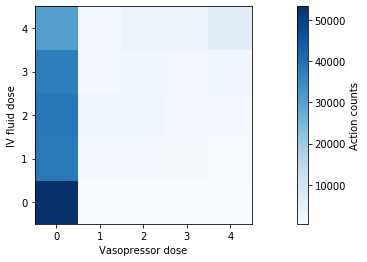

In [91]:
hist, x_edges, y_edges = np.histogram2d(disc_inp_data['iv_input'], disc_inp_data['vaso_input'], bins=5)
x_edges = np.arange(-0.5,5)
y_edges = np.arange(-0.5,5)
f, ax = plt.subplots(1, 1, figsize=(16,4))
ax.imshow(np.flipud(hist), cmap="Blues",extent=[x_edges[0], x_edges[-1],  y_edges[0],y_edges[-1]])

im = ax.pcolormesh(x_edges, y_edges, hist, cmap='Blues')
f.colorbar(im, ax=ax, label = "Action counts")

ax.grid(which='minor', color='b', linestyle='-', linewidth=1)

ax.set_xlabel('Vasopressor dose')
ax.set_ylabel('IV fluid dose')
plt.show()

In [54]:
disc_inp_data.to_csv('../data/discretised_input_data.csv', index=False)